In [19]:
# Importing Libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Reshape,Conv2DTranspose,Add,Conv2D,MaxPool2D,Dense,Flatten,InputLayer,BatchNormalization,Input,Layer)
from tensorflow.keras.optimizers import Adam

In [20]:
# Data Preparation

In [21]:
(x_train,_),(x_test,_) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train,x_test],axis=0)
mnist_digits = np.expand_dims(mnist_digits,-1).astype("float32")/255

In [22]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [23]:
len(dataset)

70000

In [24]:
BATCH_SIZE = 128
LATENT_DIM = 2

In [25]:
train_dataset = (
      dataset
      .shuffle(buffer_size=1024,reshuffle_each_iteration=True)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)

In [26]:
train_dataset

<PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [41]:
class Sampling(Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1])) 

In [28]:
# Encoder

In [42]:
encoder_inputs = Input(shape=(28,28,1))

x = Conv2D(32,3,activation='relu',strides=2,padding='same')(encoder_inputs)
x = Conv2D(64,3,activation='relu',strides=2,padding='same')(x)

x = Flatten()(x)
x = Dense(16,activation='relu')(x)

mean = Dense(LATENT_DIM)(x)
log_var = Dense(LATENT_DIM)(x)

z = Sampling()([mean,log_var])

encoder_model = Model(encoder_inputs,[z,mean,log_var],name='encoder')
encoder_model.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 14, 14, 32)   320         ['input_6[0][0]']                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_8[0][0]']               
                                                                                                  
 flatten_4 (Flatten)            (None, 3136)         0           ['conv2d_9[0][0]']               
                                                                                            

In [30]:
#Decoder

In [43]:
latent_inputs = Input(shape=(LATENT_DIM,))

x = Dense(7*7*64,activation='relu')(latent_inputs)
x = Reshape((7,7,64))(x)

x = Conv2DTranspose(64,3,activation='relu',strides=2,padding='same')(x)
x = Conv2DTranspose(32,3,activation='relu',strides=2,padding='same')(x)

decoder_output = Conv2DTranspose(1,3,activation='sigmoid',padding='same')(x)
decoder_model = Model(latent_inputs,decoder_output,name='decoder')
decoder_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_16 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        289 

In [44]:
vae_input = Input(shape=(28,28,1),name='vae_input')
x = encoder_model(vae_input)
output = decoder_model(x)
vae = Model(vae_input,output,name='vae')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vae_input (InputLayer)         [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          69076       ['vae_input[0][0]']              
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    65089       ['encoder[0][0]',                
                                                                  'encoder[0][1]',              

In [45]:
OPTIMIZER = Adam(learning_rate=1e-3)
EPOCHS = 30

In [46]:
def custom_loss(y_true,y_pred,mean,log_var):
    
    loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred),axis = (1,2)))
    loss_reg = tf.reduce_mean(tf.reduce_sum(-0.5*(log_var+1-tf.math.square(mean)-tf.math.exp(log_var)),axis = 1))
    return loss_rec+loss_reg
    

In [47]:
def training_block(x_batch):
    with tf.GradientTape() as recorder:
        z,mean,log_var = encoder_model(x_batch)
        y_pred = decoder_model(z)
        y_true = x_batch
        loss = custom_loss(y_true,y_pred,mean,log_var)
    partial_derivatives = recorder.gradient(loss,vae.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivatives,vae.trainable_weights))
    return loss

In [48]:
def learning(epochs):
    for epoch in range(1,epochs+1):
        print("Training starts for epoch number {}".format(epoch))
        
        for step,x_batch in enumerate(train_dataset):
            loss = training_block(x_batch)
        print("Training loss:",loss)
    print("Training Complete")

In [49]:
learning(EPOCHS)

Training starts for epoch number 1
Training loss: tf.Tensor(191.18294, shape=(), dtype=float32)
Training starts for epoch number 2
Training loss: tf.Tensor(169.39589, shape=(), dtype=float32)
Training starts for epoch number 3
Training loss: tf.Tensor(167.99574, shape=(), dtype=float32)
Training starts for epoch number 4
Training loss: tf.Tensor(167.90811, shape=(), dtype=float32)
Training starts for epoch number 5
Training loss: tf.Tensor(163.97935, shape=(), dtype=float32)
Training starts for epoch number 6
Training loss: tf.Tensor(154.05966, shape=(), dtype=float32)
Training starts for epoch number 7
Training loss: tf.Tensor(160.40514, shape=(), dtype=float32)
Training starts for epoch number 8
Training loss: tf.Tensor(154.69542, shape=(), dtype=float32)
Training starts for epoch number 9
Training loss: tf.Tensor(157.68199, shape=(), dtype=float32)
Training starts for epoch number 10
Training loss: tf.Tensor(159.55708, shape=(), dtype=float32)
Training starts for epoch number 11
Tra

In [62]:
scale = 2
n = 16

In [63]:
grid_x = np.linspace(-scale,scale,16)
grid_y = np.linspace(-scale,scale,16)

In [64]:
print(grid_x,grid_y)

[-2.         -1.73333333 -1.46666667 -1.2        -0.93333333 -0.66666667
 -0.4        -0.13333333  0.13333333  0.4         0.66666667  0.93333333
  1.2         1.46666667  1.73333333  2.        ] [-2.         -1.73333333 -1.46666667 -1.2        -0.93333333 -0.66666667
 -0.4        -0.13333333  0.13333333  0.4         0.66666667  0.93333333
  1.2         1.46666667  1.73333333  2.        ]


In [65]:
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 24ms/step


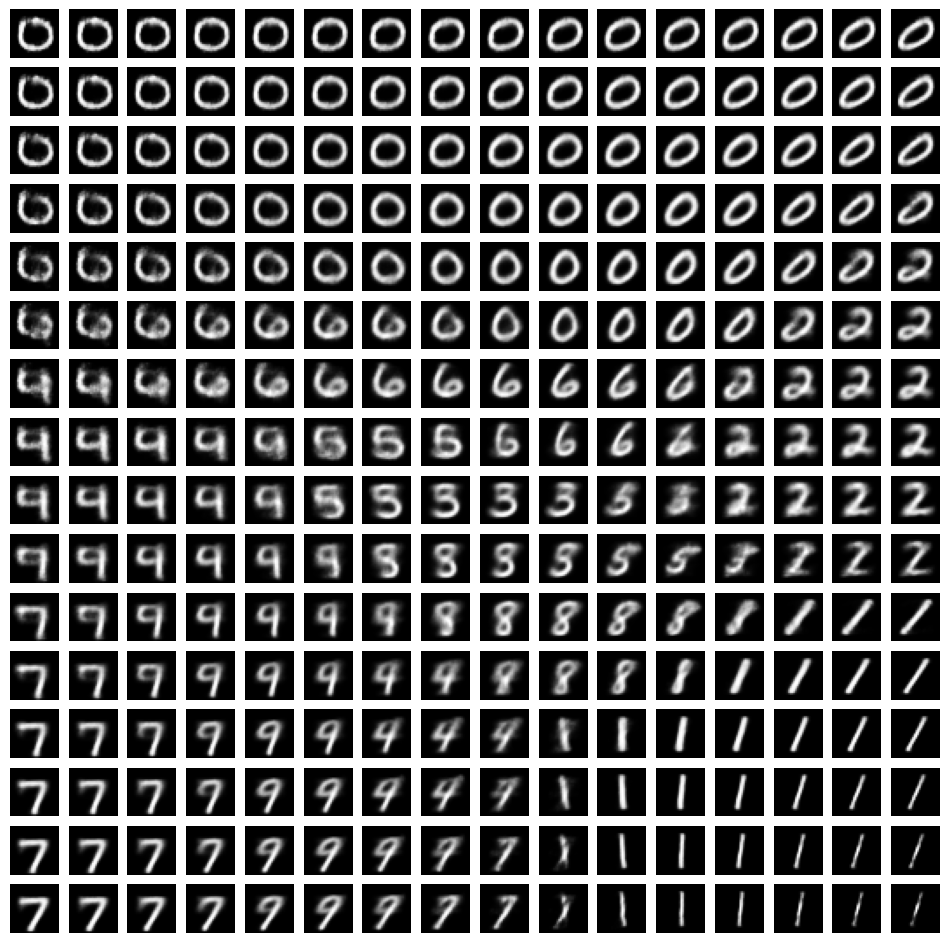

In [66]:
plt.figure(figsize=(12,12))
k = 0
for i in grid_x:
    for j in grid_y:
        ax = plt.subplot(n,n,k+1)
        input = tf.constant([[i,j]])
        out = vae.layers[2].predict(input)[0][...,0]
        plt.imshow(out,cmap = 'gray')
        plt.axis('off')
        k = k+1

In [68]:
print(vae.layers[2].predict(tf.constant([[-2,2]]))[0][...,0].shape)

1/1 [==============================] - 0s 18ms/step
(28, 28)
